# UNET SEGMENTATION

Arxiv Link: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>

<ul>
<li>UNet is a fully convolutional network(FCN) that does image segmentation. Its goal is to predict each pixel's class.</li>
 
<li>UNet is built upon the FCN and modified in a way that it yields better segmentation in medical imaging.</li>
</ul>

## 1.1 Architecture

<img src="images/u-net-architecture.png"/>

<h3>UNet Architecture has 3 parts:</h3>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h3>Upsampling Path: </h3> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.

## 1.2 Advantages
<h3> Advantages: </h3>
<ol>
    <li>The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.</li>
    <li>No Dense layer is used, so image sizes can be used.</li>
</ol>

## 1.3 Dataset
Link: <a href="https://www.kaggle.com/c/data-science-bowl-2018">Data Science Bowl 2018</a>
Find the nuclei in divergent images to advance medical discovery

## 1.4 Code

In [1]:
## Imports
import os
import os.path
import sys
import random


import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing.image import ImageDataGenerator



## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Sample Config File

In [3]:
"""import json
with open('/Users/vasudevsharma/Desktop/axondeepseg-master-2/AxonDeepSeg/models/default_SEM_model_v1/config_network.json') as djson:
    training_config = json.load(djson)
print(training_config) """
# Example of network configuration for TEM data (small network trainable on a Titan X GPU card)
training_config = {
    
# General parameters:    
  "n_classes": 3,  # Number of classes. For this application, the number of classes should be set to **3** (i.e. axon pixel, myelin pixel, or background pixel).
  "thresholds": [0, 0.2, 0.8],  # Thresholds for the 3-class classification problem. Do not modify.  
  "trainingset_patchsize": 512,  # Patch size of the training set in pixels (note that the patches have the same size in both dimensions).  
  "trainingset": "TEM_3c_512",  # Name of the training set.
  "batch_size": 8,  # Batch size, i.e. the number of training patches used in one iteration of the training. Note that a larger batch size will take more memory.

# Network architecture parameters:     
  "depth": 4,  # Depth of the network (i.e. number of blocks of the U-net).
  "convolution_per_layer": [2, 2, 2, 2],  # Number of convolution layers used at each block.
  "size_of_convolutions_per_layer": [[5, 5], [3, 3], [3, 3], [3, 3]],  # Kernel size of each convolution layer of the network.
  "features_per_convolution": [[[1, 16], [16, 16]], [[16, 32], [32, 32]], [[32, 64], [64, 64]], [[64, 128], [128, 128]]],  # Number of features of each convolution layer.
  "downsampling": "convolution",  # Type of downsampling to use in the downsampling layers of the network. Option "maxpooling" for standard max pooling layer or option "convolution" for learned convolutional downsampling.
  "dropout": 0.75,  # Dropout to use for the training. Note: In TensorFlow, the keep probability is used instead. For instance, setting this param. to 0.75 means that 75% of the neurons of the network will be kept (i.e. dropout of 25%).
     
# Learning rate parameters:    
  "learning_rate": 0.01,  # Learning rate to use in the training.  
  "learning_rate_decay_activate": True,  # Set to "True" to use a decay on the learning rate.  
  "learning_rate_decay_period": 24000,  # Period of the learning rate decay, expressed in number of images (samples) seen.
  "learning_rate_decay_type": "polynomial",  # Type of decay to use. An exponential decay will be used by default unless this param. is set to "polynomial" (to use a polynomial decay).
  "learning_rate_decay_rate": 0.99,  # Rate of the decay to use for the exponential decay. This only applies when the user does not set the decay type to "polynomial".
    
# Batch normalization parameters:     
  "batch_norm_activate": True,  # Set to "True" to use batch normalization during the training.
  "batch_norm_decay_decay_activate": True,  # Set to "True" to activate an exponential decay for the batch normalization step of the training.  
  "batch_norm_decay_starting_decay": 0.7,  # The starting decay value for the batch normalization. 
  "batch_norm_decay_ending_decay": 0.9,  # The ending decay value for the batch normalization.
  "batch_norm_decay_decay_period": 16000,  # Period of the batch normalization decay, expressed in number of images (samples) seen.
        
# Weighted cost parameters:    
  "weighted_cost-activate": True,  # Set to "True" to use weights based on the class in the cost function for the training.
  "weighted_cost-balanced_activate": True,  # Set to "True" to use weights in the cost function to correct class imbalance. 
  "weighted_cost-balanced_weights": [1.1, 1, 1.3],  # Values of the weights for the class imbalance. Typically, larger weights are assigned to classes with less pixels to add more penalty in the cost function when there is a misclassification. Order of the classes in the weights list: background, myelin, axon.
  "weighted_cost-boundaries_sigma": 2,  # Set to "True" to add weights to the boundaries (e.g. penalize more when misclassification happens in the axon-myelin interface).
  "weighted_cost-boundaries_activate": False,  # Value to control the distribution of the boundary weights (if activated). 
    
# Data augmentation parameters:
  "da-type": "all",  # Type of data augmentation procedure. Option "all" applies all selected data augmentation transformations sequentially, while option "random" only applies one of the selected transformations (randomly) to the sample(s). List of available data augmentation transformations: 'random_rotation', 'noise_addition', 'elastic', 'shifting', 'rescaling' and 'flipping'. 
  "da-0-shifting-activate": True, 
  "da-1-rescaling-activate": False,
  "da-2-random_rotation-activate": False,  
  "da-3-elastic-activate": True, 
  "da-4-flipping-activate": True, 
  "da-5-noise_addition-activate": False
}




## Data Generator

In [4]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size = 512, thresh_indices = [0, 0.2, 0.8]):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        self.thresh_indices = thresh_indices
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path,  'image_' + id_name) + ".png"
        mask_path = os.path.join(self.path,  'mask_' + id_name) + ".png"
        #all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path)
        
        #image = np.reshape(image, (self.image_size, self.image_size,1))
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        mask = descritize_mask(mask, self.thresh_indices)
        #print(mask.shape)
        #mask = np.reshape(mask, (self.image_size, self.image_size,3))
        #mask = np.zeros((self.image_size, self.image_size, 1))
        """
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
        """
        ## Normalizaing 
       # image = image/255.0
        #mask = mask/255.0
        #image = image.reshape((512* 512, 3))
        #mask  = mask.reshape((512*512, 3))

        
        return (image, mask)
    
    def __getitem__(self, index):
        
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
  
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return (image, mask)
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    

In [5]:
def labellize_mask_2d(patch, thresh_indices=[0, 0.2, 0.8]):
    '''
    Process a patch with 8 bit pixels ([0-255]) so that the pixels between two threshold values are set to the closest threshold, effectively
    enabling the creation of a mask with as many different values as there are thresholds.

    Returns mask in [0-1] domain
    '''
    mask = np.zeros_like(patch)
    for indice in range(len(thresh_indices)-1):

        thresh_inf_8bit = 255*thresh_indices[indice]
        thresh_sup_8bit = 255*thresh_indices[indice+1]

        idx = np.where((patch >= thresh_inf_8bit) & (patch < thresh_sup_8bit)) # returns (x, y) of the corresponding indices
        mask[idx] = np.mean([thresh_inf_8bit/255,thresh_sup_8bit/255])

    mask[(patch >= 255*thresh_indices[-1])] = 1

    return patch


In [6]:
def descritize_mask(mask, thresh_indices):
# Discretization of the mask
        mask = labellize_mask_2d(mask, thresh_indices) # mask intensity float between 0-1

        # Working out the real mask (sparse cube with n depth layer, one for each class)
        n = len(thresh_indices) # number of classes
        thresh_indices = [255*x for x in thresh_indices]
        real_mask = np.zeros([mask.shape[0], mask.shape[1], n])

        for class_ in range(n-1):
            real_mask[:,:,class_] = (mask[:,:] >= thresh_indices[class_]) * (mask[:,:] <  thresh_indices[class_+1])
        real_mask[:,:,-1] = (mask[:,:] >= thresh_indices[-1])
        real_mask = real_mask.astype(np.uint8)

        return real_mask

In [7]:
"""# Make an iterator to extract images from the tensor dataset
frame_batches = tf.compat.v1.data.make_one_shot_iterator(frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    frame = frame_batches.get_next().eval(session= sess)
    mask = mask_batches.next().numpy().astype(np.uint8)
    
    #Plot the corresponding frames and masks
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(frame)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
    plt.show()"""

'# Make an iterator to extract images from the tensor dataset\nframe_batches = tf.compat.v1.data.make_one_shot_iterator(frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator\nmask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)\n\nn_images_to_show = 5\n\nfor i in range(n_images_to_show):\n    \n    # Get the next image from iterator\n    frame = frame_batches.get_next().eval(session= sess)\n    mask = mask_batches.next().numpy().astype(np.uint8)\n    \n    #Plot the corresponding frames and masks\n    fig = plt.figure()\n    fig.add_subplot(1,2,1)\n    plt.imshow(frame)\n    fig.add_subplot(1,2,2)\n    plt.imshow(mask)\n    plt.show()'

In [8]:
"""DATA_PATH = 'TEM_striatum/data/Train/'

# Create folders to hold images and masks

folders = ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)"""

"DATA_PATH = 'TEM_striatum/data/Train/'\n\n# Create folders to hold images and masks\n\nfolders = ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']\n\n\nfor folder in folders:\n    try:\n        os.makedirs(DATA_PATH + folder)\n    except Exception as e: print(e)"

## Hyperparameters

In [81]:
image_size = 512
train_path = "TEM_striatum/data/Train/"
epochs = 400
batch_size = 8


## Training Ids
no_train_images =  int(len(os.listdir(train_path))/2)
train_ids = [str(i) for i in range(no_train_images) ]

print(train_ids)



['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']


In [82]:
## Validation Data Size
valid_path = "TEM_striatum/data/Validation/"


## Training Ids
no_valid_images =  int(len(os.listdir(valid_path))/2)
valid_ids = [str(i) for i in range(no_valid_images) ]

print(valid_ids)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']


In [83]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size, thresh_indices = training_config['thresholds'])
x, y= gen.__getitem__(0)

print(x.shape, y.shape)

(8, 512, 512, 3) (8, 512, 512, 3)


In [84]:
gen = DataGen(valid_ids, valid_path, batch_size=batch_size, image_size=image_size,  thresh_indices = training_config['thresholds'])
x, y= gen.__getitem__(0)

print(x.shape, y.shape)

(8, 512, 512, 3) (8, 512, 512, 3)


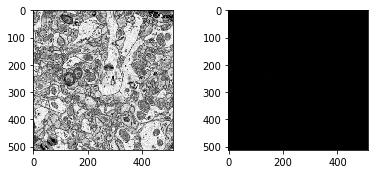

In [85]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y[r])

In [86]:
"""# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1


"""

'# Normalizing only frame images, since masks contain label info\ndata_gen_args = dict(rescale=1./255)\nmask_gen_args = dict()\n\ntrain_frames_datagen = ImageDataGenerator(**data_gen_args)\ntrain_masks_datagen = ImageDataGenerator(**mask_gen_args)\nval_frames_datagen = ImageDataGenerator(**data_gen_args)\nval_masks_datagen = ImageDataGenerator(**mask_gen_args)\n\n# Seed defined for aligning images and their masks\nseed = 1\n\n\n'

## Data Augmentation

In [87]:
"""data_gen_args = dict(featurewise_center=True,
featurewise_std_normalization=True,
rotation_range=90.,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

"""

'data_gen_args = dict(featurewise_center=True,\nfeaturewise_std_normalization=True,\nrotation_range=90.,\nwidth_shift_range=0.1,\nheight_shift_range=0.1,\nzoom_range=0.2)\nimage_datagen = ImageDataGenerator(**data_gen_args)\nmask_datagen = ImageDataGenerator(**data_gen_args)\n\n'

In [88]:
!ls

AxonDeepSeg	       LICENSE		 sbin
bin		       LICENSE.txt	 set_config.py
CHANGELOG.md	       __MACOSX		 setup.py
compiler_compat        man		 share
condabin	       mkspecs		 shell
conda-meta	       models		 ssl
CONTRIBUTING.rst       notebooks	 TEM_striatum
data		       phrasebooks	 TEM_striatum.zip
doc		       pkgs		 test
docs		       plugins		 train_network_pytorch.ipynb
envs		       postBuild	 translations
etc		       qml		 unet-segmentation.ipynb
include		       README.md	 UNetW.h5
labelled_datasets.zip  requirements.txt  Untitled.ipynb
lib		       resources	 var
libexec		       runtime.txt	 x86_64-conda_cos6-linux-gnu


In [89]:
"""
seed = 1

image_generator = image_datagen.flow_from_directory(
'TEM_striatum/data/Train',
class_mode=None,
seed=seed)

mask_generator = mask_datagen.flow_from_directory(
'TEM_striatum/data/Train',
class_mode=None,
seed=seed)"""

"\nseed = 1\n\nimage_generator = image_datagen.flow_from_directory(\n'TEM_striatum/data/Train',\nclass_mode=None,\nseed=seed)\n\nmask_generator = mask_datagen.flow_from_directory(\n'TEM_striatum/data/Train',\nclass_mode=None,\nseed=seed)"

## Different Convolutional Blocks

In [90]:
"""def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

"""

'def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):\n    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)\n    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)\n    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)\n    return c, p\n\ndef up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):\n    us = keras.layers.UpSampling2D((2, 2))(x)\n    concat = keras.layers.Concatenate()([us, skip])\n    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)\n    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)\n    return c\n\ndef bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):\n    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)\n    c = keras.layers.Conv2D(filters, kern

## UNet Model

In [91]:


# ------------------------ NETWORK STRUCTURE


def uconv_net(training_config,bn_updated_decay = None, verbose = True):
    """
    Create the U-net.
    Input :
        x : TF object to define, ensemble des patchs des images :graph input
        config : dict : described in the header.
        image_size : int : The image size

    Output :
        The U-net.
    """
    
    # Load the variables
    image_size = training_config["trainingset_patchsize"]
    n_classes = training_config["n_classes"]
    depth = training_config["depth"]
    dropout = training_config["dropout"]
    number_of_convolutions_per_layer = training_config["convolution_per_layer"]
    size_of_convolutions_per_layer = training_config["size_of_convolutions_per_layer"]
    features_per_convolution = training_config["features_per_convolution"]
    downsampling = training_config["downsampling"]
    activate_bn = training_config["batch_norm_activate"]
    if bn_updated_decay is None:
        bn_decay = training_config["batch_norm_decay_starting_decay"]
    else:
        bn_decay = bn_updated_decay

    # Input picture shape is [batch_size, height, width, number_channels_in] (number_channels_in = 1 for the input layer)
    
    data_temp_size = [image_size]
    relu_results = []

    ####################################################################
    ######################### CONTRACTION PHASE ########################
    ####################################################################
    


   # print(data_temp)

    #X = Input((image_size*image_size, 3))
    X = Input((image_size, image_size, 3))
 
    net = X
    data_temp = X
   # print(net.shape)
    #print(depth, number_of_convolutions_per_layer)
    for i in range(depth):

        for conv_number in range(number_of_convolutions_per_layer[i]):
            
            if verbose:
                #print(('Layer: ', i, ' Conv: ', conv_number, 'Features: ', features_per_convolution[i][conv_number]))
                #print(('Size:', size_of_convolutions_per_layer[i][conv_number]))
                
                net = conv_relu(net, filters = features_per_convolution[i][conv_number][1], kernel_size = size_of_convolutions_per_layer[i][conv_number], strides = 1 , activation = 'relu', kernel_initializer = 'glorot_normal', activate_bn = True, bn_decay = 0.999, keep_prob=1.0)
               
        relu_results.append(net) # We keep them for the upconvolutions
       


        if downsampling == 'convolution':
              
            net = downconv(net, filters = features_per_convolution[i][conv_number][1], kernel_size = 5, strides = 2, activation = 'relu', kernel_initializer = 'glorot_normal', activate_bn = True, bn_decay = 0.999)
      
        else: 

            net = MaxPooling2D((2, 2), padding = 'valid', strides = 2,  name ='downmp-d'+str(i))(net)

        data_temp_size.append(data_temp_size[-1] // 2)
        data_temp = net
             


    ####################################################################
    ########################## EXPANSION PHASE #########################
    ####################################################################
    
    for i in range(depth):        
        # Upsampling
        print("Upsampling")
        net = UpSampling2D(( 2,  2))(net)
     

        # Convolution
        net = conv_relu(net, filters = features_per_convolution[depth - i - 1][-1][1], kernel_size = 2, strides = 1 , activation = 'relu', kernel_initializer = 'glorot_normal', activate_bn = True, bn_decay = 0.999, keep_prob=1.0)
        
        data_temp_size.append(data_temp_size[-1] * 2)
        
       # x = Lambda(lambda x: tf.reshape(x, [-1, 1]))(x)
        # concatenation (see U-net article)
        net = Concatenate(axis = 3)([relu_results[depth-i-1],net])
      



        """net = tf.concat(values=[tf.slice(relu_results[depth-i-1], [0, 0, 0, 0], [-1, data_temp_size[depth-i-1],
                                                             data_temp_size[depth-i-1], -1]), net], axis=3)"""
        
        # Classic convolutions
        for conv_number in range(number_of_convolutions_per_layer[depth - i - 1]):
            """if verbose:
                print(('Layer: ', i, ' Conv: ', conv_number, 'Features: ', features_per_convolution[i][conv_number]))
                print(('Size:', size_of_convolutions_per_layer[i][conv_number]))"""

            net = conv_relu(net, filters = features_per_convolution[depth - i - 1][conv_number][1], kernel_size = size_of_convolutions_per_layer[depth - i - 1][conv_number], strides = 1 , activation = 'relu', kernel_initializer = 'glorot_normal', activate_bn = True, bn_decay = 0.999, keep_prob=1.0)
            
            
        data_temp = net


   
    net = Conv2D(filters = n_classes, kernel_size = 1, strides = 1, name = 'finalconv', padding = 'same',   activation = "softmax")(net)

  
    # Adding summary of the activations for the last convolution
    #tf.summary.histogram('activations_last', net)
    
    # We also display the weights of the first kernel (can help to detect some mistakes)
    #first_layer_weights_reshaped = visualize_first_layer(weights['wc'][0][0], size_of_convolutions_per_layer[0][0], features_per_convolution[0][0][1])
    #tf.summary.image("Visualize_kernel", first_layer_weights_reshaped)
    
    # Finally we compute the activations of the last layer
    """model = tf.reshape(net,[tf.shape(net)[0], data_temp_size[-1] * data_temp_size[-1], n_classes])

    
    
    """
    #net = Reshape((-1, 3))(net)
   # net = Reshape((-1, 3))(net)



    model = Model(inputs = X, outputs = net)

    

    return model

        
    
  



In [92]:

#### loss and metrics #####

def dice_coef(y_true, y_pred, smooth=1):
    """Compute Dice Coefficient between prediction and Ground Truth
    :param y_true: ground truth
    :param y_pred: prediction
    :param smooth: avoid division by 0
    :return: dice coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    """Dice loss to train a network
    :param y_true: ground truth
    :param y_pred: prediction
    :return: dice loss function
    """
    return 1 - dice_coef(y_true, y_pred)


def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

In [93]:
#defining weighted cross entropy for miss classification
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask


In [94]:
def range_transform(sample):
    """
    Range normalization for 255 range of values
    :param sample: numpy array for normalize
    :return: normalize numpy array
    """
    if (np.max(sample) == 1):
        sample = sample * 255

    m = 255 / (np.max(sample) - np.min(sample))
    n = 255 - m * np.max(sample)
    return (m * sample + n) / 255


def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
"""
def compute_uncertain(sample, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param model: unet model with Dropout layers.
    :return: averaged-thresholded predictions after nb_steps_prediction samples
    :return: overall uncertainty (not map)
    :return: uncertainty_map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)
    # averaged-thresholded predictions after np_step_prediction predicted samples
    X_prediction = cv2.threshold(np.mean(X, axis=0), threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(1 - prediction))
        return X_prediction, np.sum(np.multiply(var, transform)),  np.multiply(var, transform)

    else:
        return X_prediction, np.sum(np.sqrt(np.var(X, axis=0))), np.var(X, axis=0)


def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform
    else:
        return np.var(X, axis=0) 
"""

In [95]:
 def conv_relu(x, filters , kernel_size , strides , activation = 'relu', kernel_initializer = 'glorot_normal', activate_bn = True, bn_decay = 0.999, keep_prob=1.0):
    if activate_bn == True:

            net = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = 'same', activation = activation, kernel_initializer = kernel_initializer)(x)
            net = BatchNormalization(axis = 3, momentum = 1 - bn_decay)(net)
            
    else: 
            net = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, activation = activation, kernel_initializer = kernel_initializer, padding = 'same')(net)
            
    net =  Dropout(rate = 1 - keep_prob)(net)
            
    return net 

   
def downconv(x, filters , kernel_size = 5, strides = 2, activation = 'relu', kernel_initializer = 'glorot_normal', activate_bn = True, bn_decay = 0.999):
    if activate_bn == True:

            net = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = 'same',activation = activation, kernel_initializer = kernel_initializer)(x)
            net = BatchNormalization(axis = 3, momentum = 1 - bn_decay)(net)

    else:

            net = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, activation = activation, kernel_initializer = kernel_initializer, padding = 'same')(net)
            
    return net





In [96]:
"""def upconv(x, n_out_chan, scope, 
              w_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
              training_phase=True, activate_bn = True, bn_decay = 0.999):
   
    
    with tf.variable_scope(scope):
        if activate_bn == True:
            net = tf.contrib.layers.conv2d(x, num_outputs=n_out_chan, kernel_size=3, stride=1, 
                                       activation_fn=tf.nn.relu, normalizer_fn=tf.contrib.layers.batch_norm,
                                       normalizer_params={'scale':True, 'is_training':training_phase,
                                                          'decay':bn_decay, 'scope':'bn'},
                                       weights_initializer = w_initializer, scope='convolution'
                                      )
        else:
            net = tf.contrib.layers.conv2d(x, num_outputs=n_out_chan, kernel_size=3, stride=1, 
                                       activation_fn=tf.nn.relu, weights_initializer = w_initializer, scope='convolution'
                                      )
        
        tf.add_to_collection('activations',net)
        return net


"""


"def upconv(x, n_out_chan, scope, \n              w_initializer=tf.contrib.layers.xavier_initializer_conv2d(),\n              training_phase=True, activate_bn = True, bn_decay = 0.999):\n   \n    \n    with tf.variable_scope(scope):\n        if activate_bn == True:\n            net = tf.contrib.layers.conv2d(x, num_outputs=n_out_chan, kernel_size=3, stride=1, \n                                       activation_fn=tf.nn.relu, normalizer_fn=tf.contrib.layers.batch_norm,\n                                       normalizer_params={'scale':True, 'is_training':training_phase,\n                                                          'decay':bn_decay, 'scope':'bn'},\n                                       weights_initializer = w_initializer, scope='convolution'\n                                      )\n        else:\n            net = tf.contrib.layers.conv2d(x, num_outputs=n_out_chan, kernel_size=3, stride=1, \n                                       activation_fn=tf.nn.relu, weights_initiali

In [97]:
 model = uconv_net(training_config,  bn_updated_decay = None, verbose = True)

Upsampling
Upsampling
Upsampling
Upsampling


In [98]:
training_config

{'n_classes': 3,
 'thresholds': [0, 0.2, 0.8],
 'trainingset_patchsize': 512,
 'trainingset': 'TEM_3c_512',
 'batch_size': 8,
 'depth': 4,
 'convolution_per_layer': [2, 2, 2, 2],
 'size_of_convolutions_per_layer': [[5, 5], [3, 3], [3, 3], [3, 3]],
 'features_per_convolution': [[[1, 16], [16, 16]],
  [[16, 32], [32, 32]],
  [[32, 64], [64, 64]],
  [[64, 128], [128, 128]]],
 'downsampling': 'convolution',
 'dropout': 0.75,
 'learning_rate': 0.01,
 'learning_rate_decay_activate': True,
 'learning_rate_decay_period': 24000,
 'learning_rate_decay_type': 'polynomial',
 'learning_rate_decay_rate': 0.99,
 'batch_norm_activate': True,
 'batch_norm_decay_decay_activate': True,
 'batch_norm_decay_starting_decay': 0.7,
 'batch_norm_decay_ending_decay': 0.9,
 'batch_norm_decay_decay_period': 16000,
 'weighted_cost-activate': True,
 'weighted_cost-balanced_activate': True,
 'weighted_cost-balanced_weights': [1.1, 1, 1.3],
 'weighted_cost-boundaries_sigma': 2,
 'weighted_cost-boundaries_activate': Fa

In [99]:
#sgd = keras.optimizers.Adam(lr=training_config['learning_rate'], decay=1e-6, momentum=0.9, nesterov=True)

In [123]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["acc",dice_coef],  sample_weight_mode='temporal')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 512, 512, 16) 1216        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 512, 512, 16) 64          conv2d_25[0][0]                  
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 512, 512, 16) 0           batch_normalization_25[0][0]     
__________________________________________________________________________________________________
conv2d_26 

## Training the model

In [124]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)



In [125]:
"""
pixels = range(512)
value = [0]+[1]*510+[2]

color_dict = dict(zip(pixels, value))
print(color_dict)"""

'\npixels = range(512)\nvalue = [0]+[1]*510+[2]\n\ncolor_dict = dict(zip(pixels, value))\nprint(color_dict)'

In [126]:
#len(y[r].reshape((-1,3)))

In [127]:
#y[r].shape


In [128]:
#image = rgb_to_onehot(y[r], color_dict)


In [129]:
#print(y[r].reshape(-1,3).shape)

In [130]:
train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size



In [132]:
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, sample_weight=dict(enumerate(training_config["weighted_cost-balanced_weights"])),)
 

TypeError: fit_generator() got an unexpected keyword argument 'sample_weight'

## Testing the model

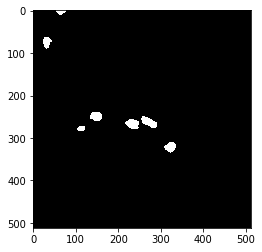

In [80]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)
y.shape
plt.imshow(y[7,:,:,2], cmap = "gray")

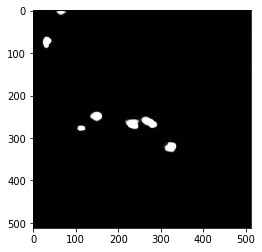

In [79]:

plt.imshow(result[7,:,:,2], cmap = "gray")


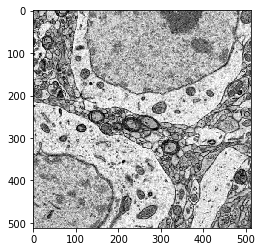

In [78]:
plt.imshow(x[7,:,:], cmap = "gray")

In [45]:

for i in range(8):
    plt.imshow(result[[i,:,:,:]])

SyntaxError: invalid syntax (<ipython-input-45-4fef44b7cb55>, line 2)

ValueError: cannot reshape array of size 786432 into shape (512,512)

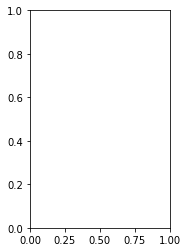

In [39]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

In [112]:
dict(enumerate(training_config["weighted_cost-balanced_weights"]))

{0: 1.1, 1: 1, 2: 1.3}